In [97]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, n):
        """
        n is the window size of the moving average
        """
        self.n = n
        self.detected = False

        # Polynomial coefficients: x = A*y^2 + B*y + C
        # Each of A, B, C is a "list-queue" with max length n
        self.A = []
        self.B = []
        self.C = []
        # Average of above
        self.A_avg = 0.
        self.B_avg = 0.
        self.C_avg = 0.

    def get_fit(self):
        return (self.A_avg, self.B_avg, self.C_avg)

    def add_fit(self, fit_coeffs):
        """
        Gets most recent line fit coefficients and updates internal smoothed coefficients
        fit_coeffs is a 3-element list of 2nd-order polynomial coefficients
        """
        # Coefficient queue full?
        q_full = len(self.A) >= self.n

        # Append line fit coefficients
        self.A.append(fit_coeffs[0])
        self.B.append(fit_coeffs[1])
        self.C.append(fit_coeffs[2])

        # Pop from index 0 if full
        if q_full:
            _ = self.A.pop(0)
            _ = self.B.pop(0)
            _ = self.C.pop(0)

        # Simple average of line coefficients
        self.A_avg = np.mean(self.A)
        self.B_avg = np.mean(self.B)
        self.C_avg = np.mean(self.C)

        return (self.A_avg, self.B_avg, self.C_avg)


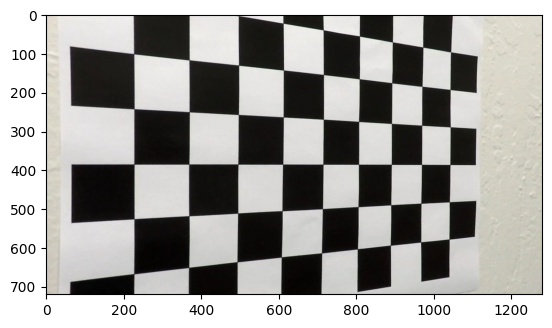

In [98]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle


def calibrate_camera():
    # Mapping each calibration image to the number of checkerboard corners
    objp_dict = {
        i: (9, 6) for i in range(1, 21)
    }
    # Adjust the corners for image 1
    objp_dict[1] = (9, 5)

    # List of object points and corners for calibration
    objp_list = []
    corners_list = []

    # Go through all images and find corners
    for k, (nx, ny) in objp_dict.items():
        # Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((nx * ny, 3), np.float32)
        objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

        # Make a list of calibration images
        fname = f'/content/camera_cal/calibration{k}.jpg'
        img = cv2.imread(fname)

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, save & draw corners
        if ret:
            # Save object points and corresponding corners
            objp_list.append(objp)
            corners_list.append(corners)

            # Draw and display the corners
            # cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            # plt.imshow(img)
            # plt.show()
            # print('Found corners for %s' % fname)
        else:
            print(f'Warning: ret = {ret} for {fname}')

    # Calibrate camera and undistort a test image
    img = cv2.imread('/content/test_images/straight_lines1.jpg')
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objp_list, corners_list, img_size, None, None)

    return mtx, dist


if __name__ == '__main__':
    mtx, dist = calibrate_camera()
    save_dict = {'mtx': mtx, 'dist': dist}
    with open('calibrate_camera.p', 'wb') as f:
        pickle.dump(save_dict, f)

    # Undistort example calibration image
    img = mpimg.imread('/content/camera_cal/calibration5.jpg')
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    plt.imshow(dst)
    # plt.savefig(r'E:\rizwan munair projects\advanced_lane_detection-master\output_images\undistort_calibration.png')
    plt.show()

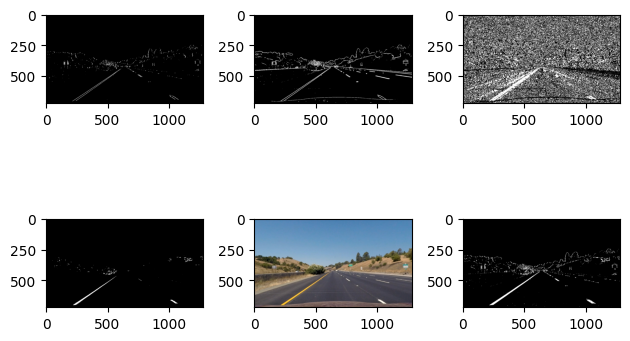

In [99]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle


def abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100):
    """
    Takes an image, gradient orientation, and threshold min/max values
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8-bit integer
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100)):
    """
    Return the magnitude of the gradient for a given sobel kernel size and threshold values
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx ** 2 + sobely ** 2)
    # Rescale to 8-bit
    scale_factor = np.max(gradmag) / 255
    gradmag = (gradmag / scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi / 2)):
    """
    Return the direction of the gradient for a given sobel kernel size and threshold values
    """
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output


def hls_thresh(img, thresh=(100, 255)):
    """
    Convert RGB to HLS and threshold to binary image using S channel
    """
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:, :, 2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output


def combined_thresh(img):
    abs_bin = abs_sobel_thresh(img, orient='x', thresh_min=50, thresh_max=255)
    mag_bin = mag_thresh(img, sobel_kernel=3, mag_thresh=(50, 255))
    dir_bin = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    hls_bin = hls_thresh(img, thresh=(170, 255))

    combined = np.zeros_like(dir_bin)
    combined[(abs_bin == 1) | ((mag_bin == 1) & (dir_bin == 1)) | (hls_bin == 1)] = 1

    return combined, abs_bin, mag_bin, dir_bin, hls_bin  # DEBUG


if __name__ == '__main__':
    img_file = '/content/test_images/straight_lines1.jpg'

    with open('/content/calibrate_camera.p', 'rb') as f:
        save_dict = pickle.load(f)
    mtx = save_dict['mtx']
    dist = save_dict['dist']

    img = mpimg.imread(img_file)
    img = cv2.undistort(img, mtx, dist, None, mtx)

    combined, abs_bin, mag_bin, dir_bin, hls_bin = combined_thresh(img)

    plt.subplot(2, 3, 1)
    plt.imshow(abs_bin, cmap='gray', vmin=0, vmax=1)
    plt.subplot(2, 3, 2)
    plt.imshow(mag_bin, cmap='gray', vmin=0, vmax=1)
    plt.subplot(2, 3, 3)
    plt.imshow(dir_bin, cmap='gray', vmin=0, vmax=1)
    plt.subplot(2, 3, 4)
    plt.imshow(hls_bin, cmap='gray', vmin=0, vmax=1)
    plt.subplot(2, 3, 5)
    plt.imshow(img)
    plt.subplot(2, 3, 6)
    plt.imshow(combined, cmap='gray', vmin=0, vmax=1)

    plt.tight_layout()
    plt.show()

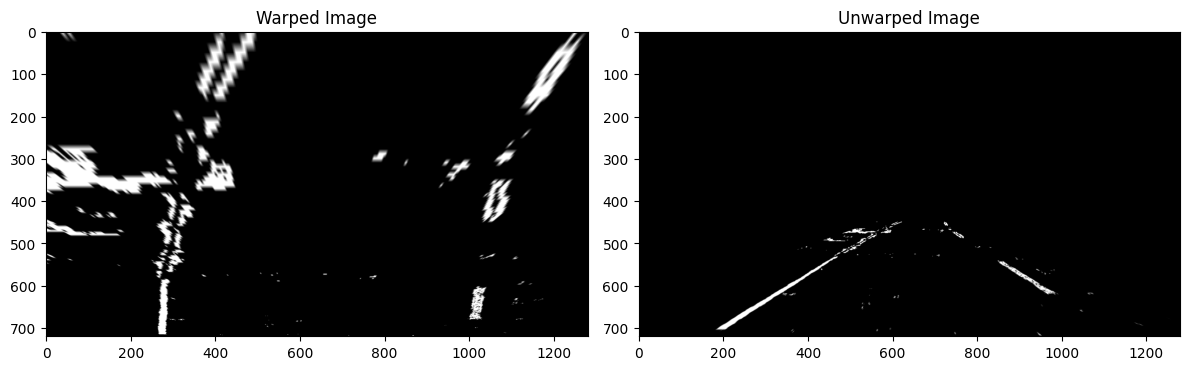

In [100]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
#from combined_thresh import combined_thresh  # Make sure this import is correct

def perspective_transform(img):
    """
    Execute perspective transform
    """
    img_size = (img.shape[1], img.shape[0])

    src = np.float32(
        [[200, 720],
         [1100, 720],
         [595, 450],
         [685, 450]])
    dst = np.float32(
        [[300, 720],
         [980, 720],
         [300, 0],
         [980, 0]])

    m = cv2.getPerspectiveTransform(src, dst)
    m_inv = cv2.getPerspectiveTransform(dst, src)

    warped = cv2.warpPerspective(img, m, img_size, flags=cv2.INTER_LINEAR)
    unwarped = cv2.warpPerspective(warped, m_inv, (warped.shape[1], warped.shape[0]), flags=cv2.INTER_LINEAR)  # DEBUG

    return warped, unwarped, m, m_inv

if __name__ == '__main__':
    img_file = '/content/test_images/test5.jpg'

    with open('/content/calibrate_camera.p', 'rb') as f:
        save_dict = pickle.load(f)
    mtx = save_dict['mtx']
    dist = save_dict['dist']

    img = mpimg.imread(img_file)
    img = cv2.undistort(img, mtx, dist, None, mtx)

    # Apply combined thresholding if defined
    img, abs_bin, mag_bin, dir_bin, hls_bin = combined_thresh(img)

    warped, unwarped, m, m_inv = perspective_transform(img)

    # Display warped and unwarped images
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(warped, cmap='gray', vmin=0, vmax=1)
    plt.title('Warped Image')

    plt.subplot(1, 2, 2)
    plt.imshow(unwarped, cmap='gray', vmin=0, vmax=1)
    plt.title('Unwarped Image')

    plt.tight_layout()
    plt.show()

In [101]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
#from combined_thresh import combined_thresh
#from perspective_transform import perspective_transform

def line_fit(binary_warped):
    """
    Find and fit lane lines
    """
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:, :], axis=0)

    # Create an output image to draw on and visualize the result
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped)) * 255).astype('uint8')

    # Find the peak of the left and right halves of the histogram
    midpoint = int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[100:midpoint]) + 100
    rightx_base = np.argmax(histogram[midpoint:-100]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = int(binary_warped.shape[0] / nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Return a dict of relevant variables
    ret = {
        'left_fit': left_fit,
        'right_fit': right_fit,
        'nonzerox': nonzerox,
        'nonzeroy': nonzeroy,
        'out_img': out_img,
        'left_lane_inds': left_lane_inds,
        'right_lane_inds': right_lane_inds
    }

    return ret

def tune_fit(binary_warped, left_fit, right_fit):
    """
    Given a previously fit line, quickly try to find the line based on previous lines
    """
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] - margin)) &
                      (nonzerox < (left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] - margin)) &
                       (nonzerox < (right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2] + margin)))

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # If we don't find enough relevant points, return all None
    min_inds = 10
    if lefty.shape[0] < min_inds or righty.shape[0] < min_inds:
        return None

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    # Return a dict of relevant variables
    ret = {
        'left_fit': left_fit,
        'right_fit': right_fit,
        'nonzerox': nonzerox,
        'nonzeroy': nonzeroy,
        'left_lane_inds': left_lane_inds,
        'right_lane_inds': right_lane_inds
    }

    return ret

def viz1(binary_warped, ret, save_file=None):
    """
    Visualize each sliding window location and predicted lane lines, on binary warped image
    save_file is a string representing where to save the image (if None, then just display)
    """
    left_fit = ret['left_fit']
    right_fit = ret['right_fit']
    nonzerox = ret['nonzerox']
    nonzeroy = ret['nonzeroy']
    out_img = ret['out_img']
    left_lane_inds = ret['left_lane_inds']
    right_lane_inds = ret['right_lane_inds']

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    # Draw the lane onto the warped blank image
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, binary_warped.shape[1])
    plt.ylim(binary_warped.shape[0], 0)
    if save_file is None:
        plt.show()
    else:
        plt.savefig(save_file)
    plt.gcf().clear()

def viz2(binary_warped, ret, save_file=None):
    """
    Visualize the predicted lane lines with margin, on binary warped image
    save_file is a string representing where to save the image (if None, then just display)
    """
    left_fit = ret['left_fit']
    right_fit = ret['right_fit']
    nonzerox = ret['nonzerox']
    nonzeroy = ret['nonzeroy']
    left_lane_inds = ret['left_lane_inds']
    right_lane_inds = ret['right_lane_inds']

    # Create an image to draw on and an image to show the selection window
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped)) * 255).astype('uint8')
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0] - 1, binary_warped.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    # Generate a polygon to illustrate the search window area
    margin = 100  # NOTE: Keep this in sync with *_fit()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx - margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx + margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx - margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx + margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0, 255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0, 255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, binary_warped.shape[1])
    plt.ylim(binary_warped.shape[0], 0)
    if save_file is None:
        plt.show()
    else:
        plt.savefig(save_file)
    plt.gcf().clear()

def calc_curve(left_lane_inds, right_lane_inds, nonzerox, nonzeroy):
    """
    Calculate radius of curvature in meters
    """
    y_eval = 719  # 720p video/image, so last (lowest on screen) y index is 719

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials to x, y in world space
    left_fit_cr = np.polyfit(lefty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty * ym_per_pix, rightx * xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.abs(2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.abs(2 * right_fit_cr[0])

    return left_curverad, right_curverad

def calc_vehicle_offset(undist, left_fit, right_fit):
    """
    Calculate vehicle offset from lane center, in meters
    """
    # Calculate vehicle center offset in pixels
    bottom_y = undist.shape[0] - 1
    bottom_x_left = left_fit[0] * (bottom_y ** 2) + left_fit[1] * bottom_y + left_fit[2]
    bottom_x_right = right_fit[0] * (bottom_y ** 2) + right_fit[1] * bottom_y + right_fit[2]
    vehicle_offset = undist.shape[1] / 2 - (bottom_x_left + bottom_x_right) / 2

    # Convert pixel offset to meters
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension
    vehicle_offset *= xm_per_pix

    return vehicle_offset

def final_viz(undist, left_fit, right_fit, m_inv, left_curve, right_curve, vehicle_offset):
    """
    Final lane line prediction visualized and overlayed on top of original image
    """
    # Generate x and y values for plotting
    ploty = np.linspace(0, undist.shape[0] - 1, undist.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    # Create an image to draw the lines on
    color_warp = np.zeros((720, 1280, 3), dtype='uint8')  # NOTE: Hard-coded image dimensions

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, m_inv, (undist.shape[1], undist.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

    # Annotate lane curvature values and vehicle offset from center
    avg_curve = (left_curve + right_curve) / 2
    label_str = 'Radius of curvature: %.1f m' % avg_curve
    result = cv2.putText(result, label_str, (30, 40), 0, 1, (0, 0, 0), 2, cv2.LINE_AA)

    label_str = 'Vehicle offset from lane center: %.1f m' % vehicle_offset
    result = cv2.putText(result, label_str, (30, 70), 0, 1, (0, 0, 0), 2, cv2.LINE_AA)

    return result

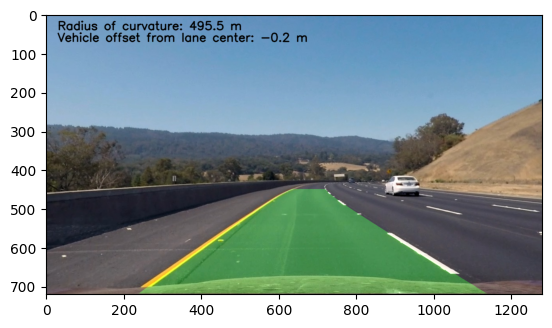

In [102]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os
# from combined_thresh import combined_thresh
# from perspective_transform import perspective_transform
# from line_fit import line_fit, viz2, calc_curve, final_viz

# Read camera calibration coefficients
with open('/content/calibrate_camera.p', 'rb') as f:
    save_dict = pickle.load(f)
mtx = save_dict['mtx']
dist = save_dict['dist']

# Define directories
image_dir = '/content/test_images'
output_dir = '/content/example_images'

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Process each image
image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

for image_file in image_files:
    img_path = os.path.join(image_dir, image_file)
    out_image_file = image_file.split('.')[0] + '.png'  # write to png format
    img = mpimg.imread(img_path)

    # Undistort image
    undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
    plt.imshow(undistorted_img)
    # plt.savefig(os.path.join(output_dir, 'undistort_' + out_image_file))

    # Thresholded binary image
    img, abs_bin, mag_bin, dir_bin, hls_bin = combined_thresh(undistorted_img)
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    # plt.savefig(os.path.join(output_dir, 'binary_' + out_image_file))

    # Perspective transform
    img, binary_unwarped, m, m_inv = perspective_transform(img)
    plt.imshow(img, cmap='gray', vmin=0, vmax=1)
    # plt.savefig(os.path.join(output_dir, 'warped_' + out_image_file))

    # Polynomial fit
    ret = line_fit(img)
    left_fit = ret['left_fit']
    right_fit = ret['right_fit']
    nonzerox = ret['nonzerox']
    nonzeroy = ret['nonzeroy']
    left_lane_inds = ret['left_lane_inds']
    right_lane_inds = ret['right_lane_inds']
    save_file = os.path.join(output_dir, 'polyfit_' + out_image_file)
    viz2(img, ret, save_file=save_file)

    # Do full annotation on original image
    orig = mpimg.imread(img_path)
    undist = cv2.undistort(orig, mtx, dist, None, mtx)
    left_curve, right_curve = calc_curve(left_lane_inds, right_lane_inds, nonzerox, nonzeroy)

    bottom_y = undist.shape[0] - 1
    bottom_x_left = left_fit[0] * (bottom_y ** 2) + left_fit[1] * bottom_y + left_fit[2]
    bottom_x_right = right_fit[0] * (bottom_y ** 2) + right_fit[1] * bottom_y + right_fit[2]
    vehicle_offset = undist.shape[1] / 2 - (bottom_x_left + bottom_x_right) / 2

    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension
    vehicle_offset *= xm_per_pix

    img = final_viz(undist, left_fit, right_fit, m_inv, left_curve, right_curve, vehicle_offset)
    plt.imshow(img)
    plt.savefig(os.path.join(output_dir, 'annotated_' + out_image_file))


In [103]:
from moviepy.editor import VideoFileClip

def check_video_metadata(file_path):
    video = VideoFileClip(file_path)
    print(f"Duration: {video.duration}")
    print(f"Frame rate: {video.fps}")
    print(f"Resolution: {video.size}")

check_video_metadata('/content/project_video.mp4')


Duration: 50.4
Frame rate: 25.0
Resolution: [1280, 720]


In [104]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from moviepy.editor import VideoFileClip

# Ensure to import or define these functions and classes
# from combined_thresh import combined_thresh
# from perspective_transform import perspective_transform
# from line_fit import line_fit, tune_fit, final_viz, calc_curve, calc_vehicle_offset
# from Line import Line

# Global variables (just to make the moviepy video annotation work)
with open('/content/calibrate_camera.p', 'rb') as f:
    save_dict = pickle.load(f)
mtx = save_dict['mtx']
dist = save_dict['dist']
window_size = 5  # how many frames for line smoothing
left_line = Line(n=window_size)
right_line = Line(n=window_size)
detected = False  # did the fast line fit detect the lines?
left_curve, right_curve = 0., 0.  # radius of curvature for left and right lanes
left_lane_inds, right_lane_inds = None, None  # for calculating curvature


def annotate_image(img_in):
    """
    Annotate the input image with lane line markings
    Returns annotated image
    """
    global mtx, dist, left_line, right_line, detected
    global left_curve, right_curve, left_lane_inds, right_lane_inds

    # Undistort, threshold, perspective transform
    undist = cv2.undistort(img_in, mtx, dist, None, mtx)
    img, abs_bin, mag_bin, dir_bin, hls_bin = combined_thresh(undist)
    binary_warped, binary_unwarped, m, m_inv = perspective_transform(img)

    if binary_warped is None or m is None or m_inv is None:
        print("Error in perspective transform.")
        return np.zeros_like(img_in)  # Return a blank image of the same shape

    # Perform polynomial fit
    if not detected:
        ret = line_fit(binary_warped)
        if ret is None:
            print("Error in line fitting.")
            return np.zeros_like(img_in)  # Return a blank image of the same shape

        left_fit = ret.get('left_fit')
        right_fit = ret.get('right_fit')
        nonzerox = ret.get('nonzerox')
        nonzeroy = ret.get('nonzeroy')
        left_lane_inds = ret.get('left_lane_inds')
        right_lane_inds = ret.get('right_lane_inds')

        if any(val is None for val in [left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds]):
            print("Error: Some line fit results are None.")
            return np.zeros_like(img_in)  # Return a blank image of the same shape

        left_fit = left_line.add_fit(left_fit)
        right_fit = right_line.add_fit(right_fit)

        left_curve, right_curve = calc_curve(left_lane_inds, right_lane_inds, nonzerox, nonzeroy)
        detected = True  # slow line fit always detects the line

    else:  # implies detected == True
        left_fit = left_line.get_fit()
        right_fit = right_line.get_fit()
        ret = tune_fit(binary_warped, left_fit, right_fit)

        if ret is None:
            print("Error in tuning fit.")
            detected = False
            return np.zeros_like(img_in)  # Return a blank image of the same shape

        left_fit = ret.get('left_fit')
        right_fit = ret.get('right_fit')
        nonzerox = ret.get('nonzerox')
        nonzeroy = ret.get('nonzeroy')
        left_lane_inds = ret.get('left_lane_inds')
        right_lane_inds = ret.get('right_lane_inds')

        if any(val is None for val in [left_fit, right_fit, nonzerox, nonzeroy, left_lane_inds, right_lane_inds]):
            print("Error: Some tuning fit results are None.")
            detected = False
            return np.zeros_like(img_in)  # Return a blank image of the same shape

        left_fit = left_line.add_fit(left_fit)
        right_fit = right_line.add_fit(right_fit)
        left_curve, right_curve = calc_curve(left_lane_inds, right_lane_inds, nonzerox, nonzeroy)

    vehicle_offset = calc_vehicle_offset(undist, left_fit, right_fit)
    if vehicle_offset is None:
        print("Error in calculating vehicle offset.")
        return np.zeros_like(img_in)  # Return a blank image of the same shape

    # Perform final visualization on top of original undistorted image
    result = final_viz(undist, left_fit, right_fit, m_inv, left_curve, right_curve, vehicle_offset)
    if result is None:
        print("Error in final visualization.")
        return np.zeros_like(img_in)  # Return a blank image of the same shape

    return result


def annotate_video(input_file, output_file):
    """ Given input_file video, save annotated video to output_file """
    video = VideoFileClip(input_file)
    annotated_video = video.fl_image(annotate_image)
    annotated_video.write_videofile(output_file, audio=False)


if __name__ == '__main__':
    # # Annotate the video
     annotate_video('/content/project_video.mp4', 'out.mp4')


    # Show example annotated image on screen for sanity check

Moviepy - Building video out.mp4.
Moviepy - Writing video out.mp4



Moviepy - Done !
Moviepy - video ready out.mp4


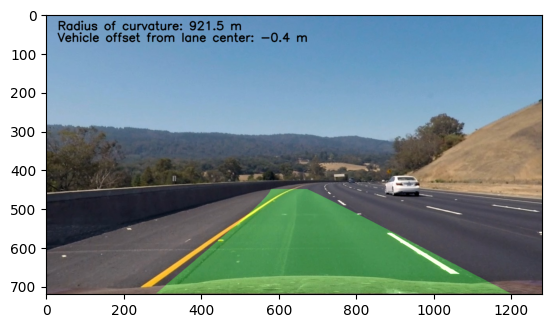

In [72]:
img_file = '/content/test_images/test3.jpg'
img = mpimg.imread(img_file)
result = annotate_image(img)
plt.imshow(result)
plt.show()

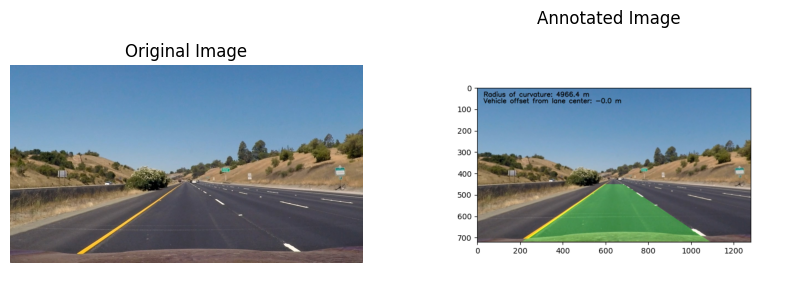

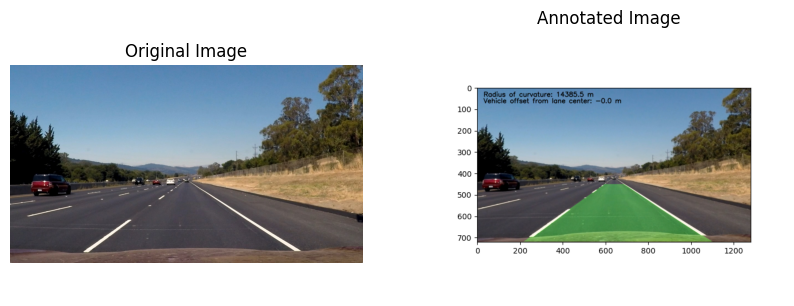

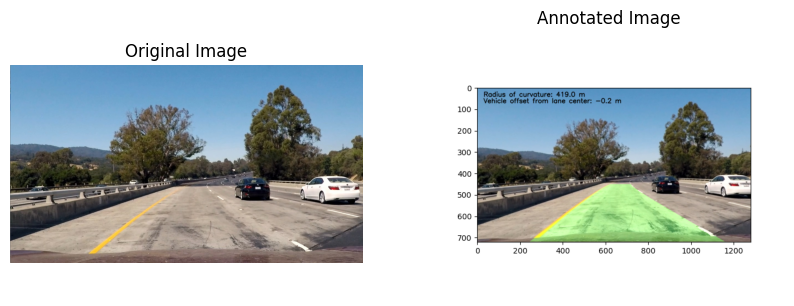

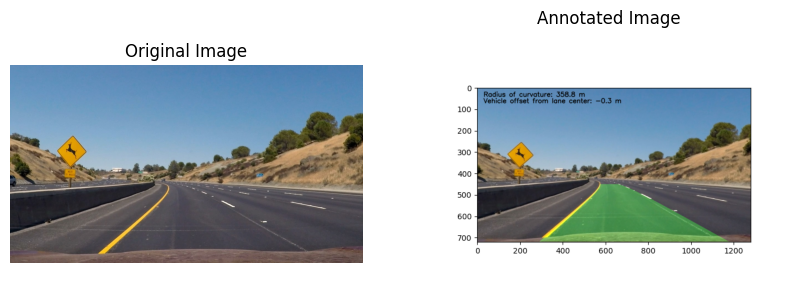

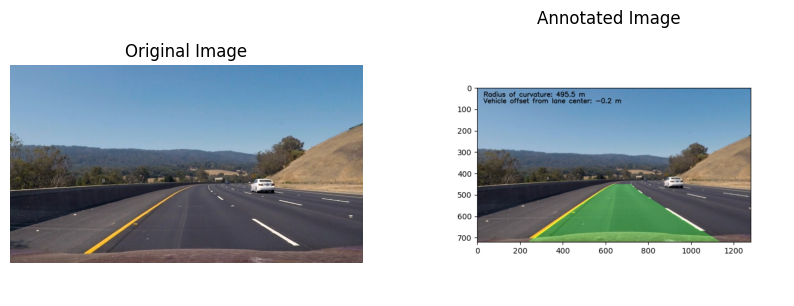

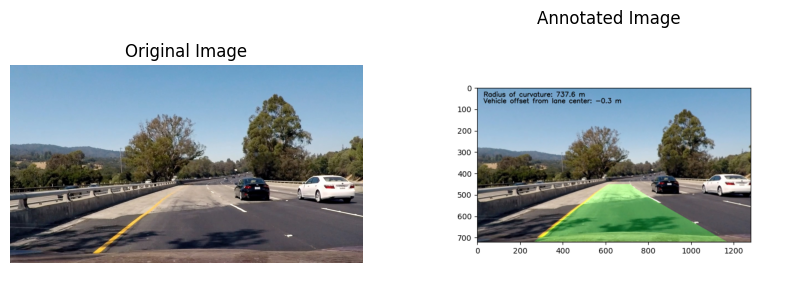

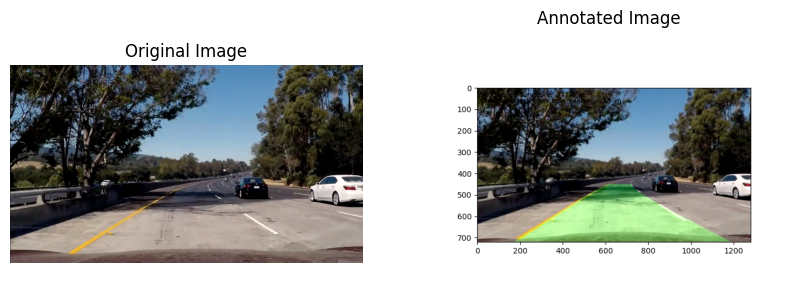

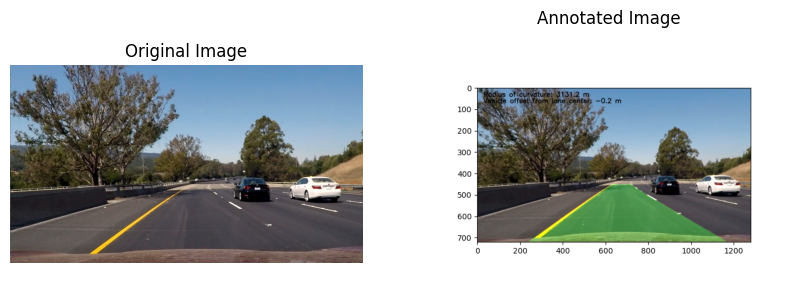

In [73]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Define directories
original_image_dir = '/content/test_images'
annotated_image_dir = '/content/example_images'

# List all image files in the original images directory
original_image_files = [f for f in os.listdir(original_image_dir) if os.path.isfile(os.path.join(original_image_dir, f))]

# Sort image files to ensure consistent pairing
original_image_files.sort()

for image_file in original_image_files:
    original_img_path = os.path.join(original_image_dir, image_file)
    annotated_img_path = os.path.join(annotated_image_dir, 'annotated_' + image_file.split('.')[0] + '.png')

    if os.path.isfile(annotated_img_path):
        # Load images
        original_img = mpimg.imread(original_img_path)
        annotated_img = mpimg.imread(annotated_img_path)

        # Plot images side by side
        plt.figure(figsize=(10, 5))

        # Original image
        plt.subplot(1, 2, 1)
        plt.imshow(original_img)
        plt.title('Original Image')
        plt.axis('off')

        # Annotated image
        plt.subplot(1, 2, 2)
        plt.imshow(annotated_img)
        plt.title('Annotated Image')
        plt.axis('off')

        # Show the plot
        plt.show()
